### LSTM

In [2]:
# importer
import yfinance as yfin
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath(".."))
from torch.nn import Module, Linear, MSELoss
from torch.nn import LSTM as torch_LSTM
from torch.optim import Adam
from ml_utils import parse_config, vizualization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection  import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [5]:
VALID_JSON={
    "data":
    {
        "type":"object",
        "properties":
        {
            "ticker":
            {
                "type":"string"
            },
            "start_date":
            {
                "type":int
            },
            "end_date":
            {
                "type":int
            },
            "params":
            {
                "type":"array",
                "minItems":1,
                "items":
                {
                    "type":"string",
                    "enum":['Open', 'Close', 'High', 'Low', 'Volume']
                },
            }
        },
        "required":["ticker", "start_date", "end_date", "params"]
    },
    "hpr_prm":
    {
        "type":"object",
        "properties":
        {
            "lr":
            {
                "type":"number",
                "minimum":0.000001,
                "maximum":1.0
            },
            "hidden_size":
            {
                "type":"number"
            },
            "num_layers":
            {
                "type":"number"
            },
            "epochs":
            {
                "type":"integer"
            },
            "seq_len":
            {
                "type":"integer"
            },
            "batch_size":
            {
                    "type":"integer"
            }
        },
        "required":["epochs", "lr", "hidden_size", "num_layers","seq_len", "batch_size"]
    },
    "opt":
    {
        "type":"object",
        "properties":
        {
            "viz_stp":
            {
                "type":"integer"
            },
            "train":
            {
                "type":"boolean"
            },
            "test":
            {
                "type":"boolean"
            },
            "mdl_src":
            {
                "type":"object",
                "properties":
                {
                    "flag":
                    {
                        "type":"boolean"
                    },
                    "path":
                    {
                        "type":"string"
                    }
                },
                "required":["flag", "path"]
            },
            "mdl_trg":
            {
                "type":"object",
                "properties":
                {
                    "flag":
                    {
                        "type":"boolean"
                    },
                    "path":
                    {
                        "type":"string"
                    }
                },
                "required":["flag", "path"]
            }
        },
        "required":["viz_stp", "mdl_src", "model_trg"]
    },
    "required":["data", "hpr_prm", "opt"]
}

In [6]:
class LSTM(Module):
    def __init__(self, input_size:int, hidden_size:int, output_size:int, num_layers:int, device):
        super().__init__()
        self.device = device
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = torch_LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :])
        return out

In [7]:
def create_data(ticker:str, start_date:str, end_date:str, params):
    df = yfin.download(ticker, start_date, end_date)
    return df[params].values.reshape(-1, 1)

def create_dataset(data:np.ndarray, seq_len:int):
    X = []
    y = []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)


In [8]:
def train(model:Module, X_train:torch.tensor, y_train:torch.tensor, criterion:MSELoss, optimizer:Adam, epochs:int, viz_stp:int, ticker:str):
    x_epoch = np.arange(0, epochs)
    y_loss = np.zeros(epochs)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        output = model(X_train)
        loss = criterion(output, y_train)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        y_loss[epoch] = loss.item()
        if epoch % viz_stp == 0:
            print(f'Epoch [{epoch}/{epochs}] finished with loss: {y_loss[epoch]}')
        
    
    vizualization(x_epoch, 'Epochs', y_loss, 'Loss', f'Loss over epochs by price on stock {ticker}')


def test(model:Module, X_test:torch.tensor, y_test:np.array, scaler:MinMaxScaler, ticker:str):
    model.eval()
    with torch.no_grad():
        predicted = model(X_test).detach().cpu().numpy()
    predicted = scaler.inverse_transform(predicted)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    plt.plot(y_test,label='Actual Sin Wave', color='blue', linestyle='-', linewidth=2)
    plt.plot(predicted, label='Predicted Sin Wave',color='red', linestyle='--', linewidth=2)    
    plt.legend()
    plt.title(f'Original vs predicted prices on stock {ticker}')
    
def learn(config:dict):
    torch.cuda.empty_cache()
    print(f'Ticker : {config['data']['ticker']}')
    print(f'From: {config['data']['start_date']}')
    print(f'To: {config['data']['end_date']}')
    print('Params:', end=' ')
    for param in config['data']['params']:
        print(param, end=' ')
    print()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    data = create_data(config['data']['ticker'].upper(), config['data']['start_date'], config['data']['end_date'], config['data']['params'])
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    X, y = create_dataset(data, config['hpr_prm']['seq_len'])
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, shuffle=False)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)

    model = LSTM(1, config['hpr_prm']['hidden_size'], 1, config['hpr_prm']['num_layers'], device).to(device)
    if config['opt']['mdl_src']['flag']:
        model.load_state_dict(torch.load(config['opt']['mdl_src']['path']))
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr = config['hpr_prm']['lr'])
    if config['opt']['train']:
        train(model, X_train.to(device), y_train.to(device), criterion, optimizer, config['hpr_prm']['epochs'], config['opt']['viz_stp'], config['data']['ticker'])
    if config['opt']['test']:
        test(model, X_test.to(device), y_test, scaler, config['data']['ticker'])
    if config['opt']['mdl_trg']['flag']:
        torch.save(model.state_dict(), config['opt']['mdl_trg']['path'])

### Test 1
* "lr":0.001,
* "hidden_size":128,
* "num_layers":2,
* "epochs":200,
* "seq_len":50

[*********************100%***********************]  1 of 1 completed

Ticker : AAPL
From: 2018-01-01
To: 2023-01-01
Params: Close 


Epoch [0/100] finished with loss: 0.20036138594150543
Epoch [20/100] finished with loss: 0.04222284257411957
Epoch [40/100] finished with loss: 0.0028921798802912235
Epoch [60/100] finished with loss: 0.0011822760570794344
Epoch [80/100] finished with loss: 0.0007006462546996772


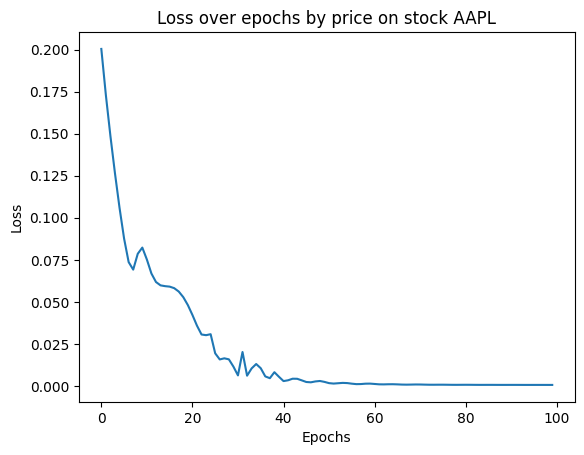

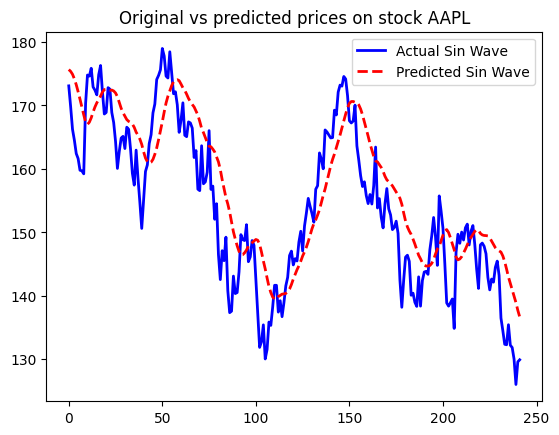

In [38]:
config = parse_config('config/config6.json', VALID_JSON)
learn(config)

### Test 2
* "lr":0.001,
* "hidden_size":300,
* "num_layers":2,
* "epochs":200,
* "seq_len":50

[*********************100%***********************]  1 of 1 completed

Ticker : AAPL
From: 2018-01-01
To: 2023-01-01
Params: Close 


Epoch [0/100] finished with loss: 0.2529212236404419
Epoch [20/100] finished with loss: 0.016506124287843704
Epoch [40/100] finished with loss: 0.0011138493428006768
Epoch [60/100] finished with loss: 0.0004902258515357971
Epoch [80/100] finished with loss: 0.000471304461825639


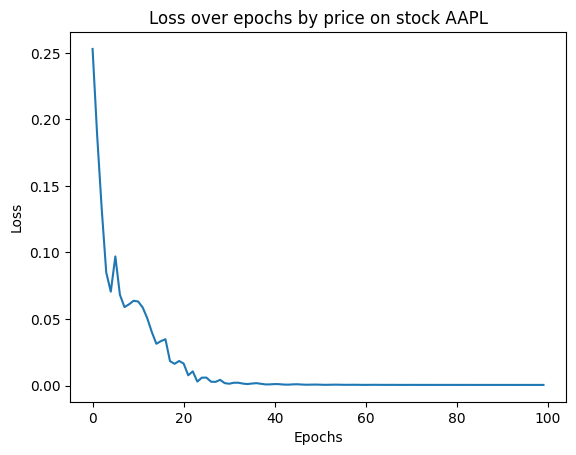

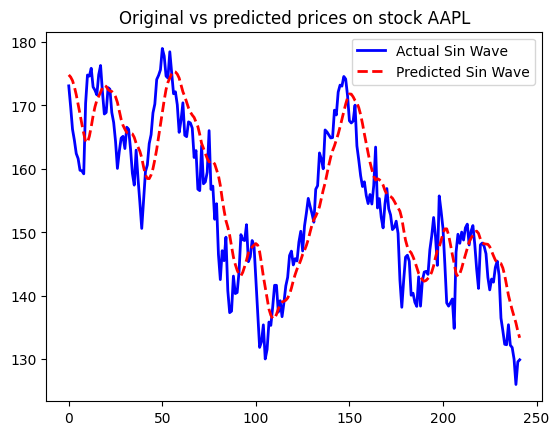

In [39]:
config = parse_config('config/config7.json', VALID_JSON)
learn(config)

### Test 3
* "lr":0.001,
* "hidden_size":128,
* "num_layers":2,
* "epochs":200,
* "seq_len":25

[*********************100%***********************]  1 of 1 completed

Ticker : AAPL
From: 2018-01-01
To: 2023-01-01
Params: Close 


Epoch [0/100] finished with loss: 0.18417184054851532
Epoch [20/100] finished with loss: 0.036218512803316116
Epoch [40/100] finished with loss: 0.0036465502344071865
Epoch [60/100] finished with loss: 0.0012021788861602545
Epoch [80/100] finished with loss: 0.0006646888214163482


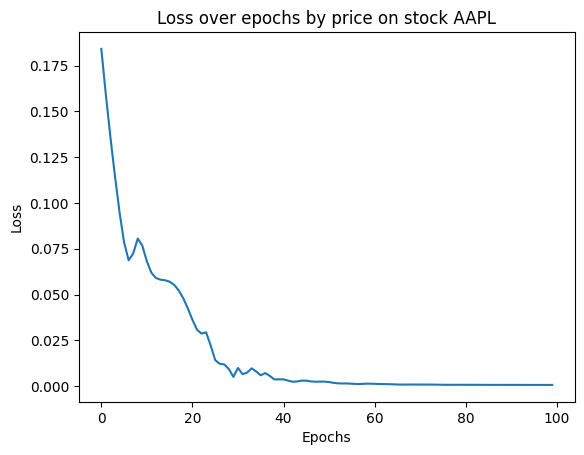

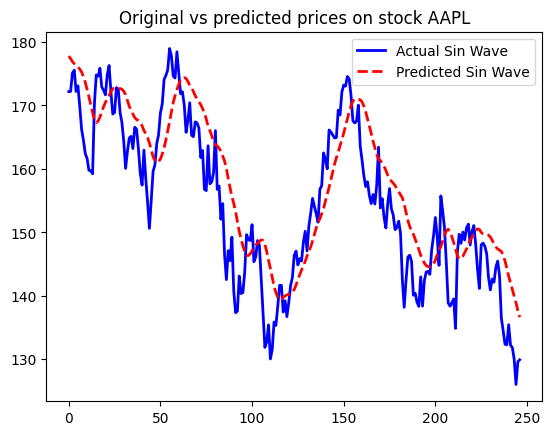

In [40]:
config = parse_config('config/config8.json', VALID_JSON)
learn(config)

Ticker : AAPL
From: 2018-01-01
To: 2023-01-01
Params: Close 


[*********************100%***********************]  1 of 1 completed


Epoch [0/75] finished with loss: 0.2017393559217453
Epoch [10/75] finished with loss: 0.0618482269346714
Epoch [20/75] finished with loss: 0.019401149824261665
Epoch [30/75] finished with loss: 0.0024359438102692366
Epoch [40/75] finished with loss: 0.0010018019238486886
Epoch [50/75] finished with loss: 0.0005787257687188685
Epoch [60/75] finished with loss: 0.0004975801566615701
Epoch [70/75] finished with loss: 0.0004889367264695466


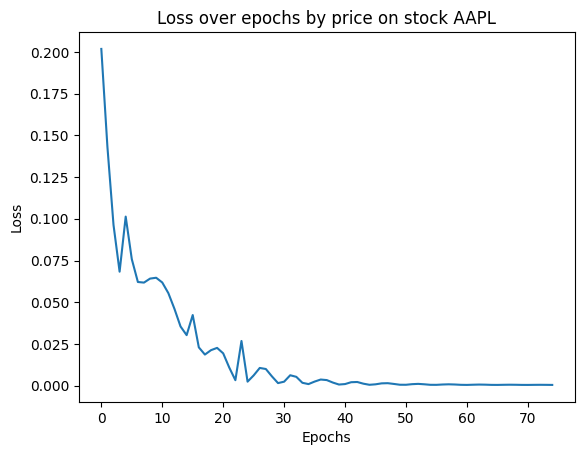

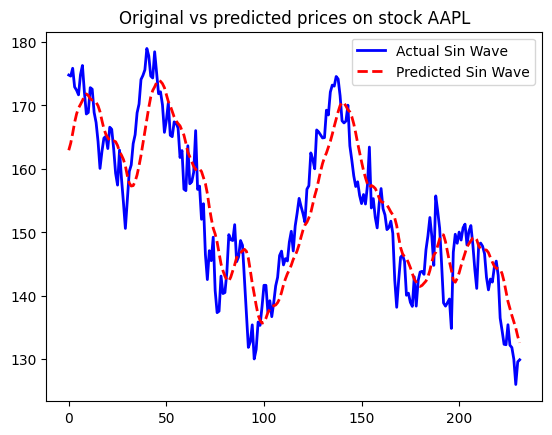

In [9]:
config = parse_config('config/config10.json', VALID_JSON)
learn(config)

[*********************100%***********************]  1 of 1 completed

Ticker : AAPL
From: 2018-01-01
To: 2023-01-01
Params: Open Close 


Epoch [0/70] finished with loss: 0.2210342139005661
Epoch [10/70] finished with loss: 0.06401308625936508
Epoch [20/70] finished with loss: 0.017381565645337105
Epoch [30/70] finished with loss: 0.0018515585688874125
Epoch [40/70] finished with loss: 0.0002913656644523144
Epoch [50/70] finished with loss: 0.00035183827276341617
Epoch [60/70] finished with loss: 0.00034839066211134195


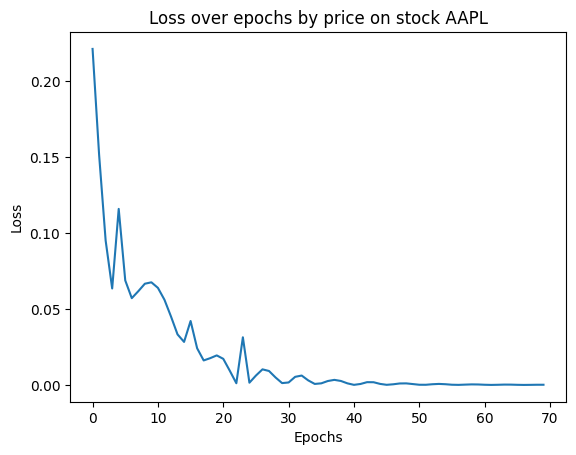

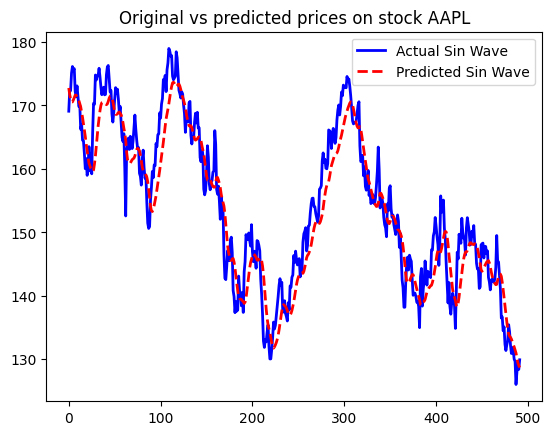

In [13]:
config = parse_config('config/config11.json', VALID_JSON)
learn(config)

[*********************100%***********************]  1 of 1 completed

Ticker : GOOG
From: 2018-01-01
To: 2023-01-01
Params: Open Close 



C:\Users\user\AppData\Local\Temp\ipykernel_27108\3707538656.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config['opt']['mdl_src']['

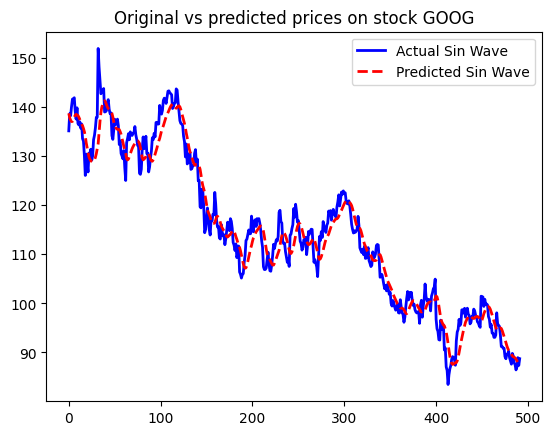

In [14]:
config = parse_config('config/config12.json', VALID_JSON)
learn(config)